In [42]:
# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, Concatenate, Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os

## 0.Preprocesamiento
Voy a inspeccionar cuestiones claves, quiero saber si por algún error hay imágenes como tipo objeto, si los datos de ambos csvs tienen valores nulos y si el número de filas/samples de ambos csv son los mismos (deberían serlo dado que queremos esa relación 1-1). Y concatenaré los datos de ambos csvs.

In [43]:
os.getcwd()
df_tab = pd.read_csv("/content/HAM10000_metadata.csv")
df_tab.shape

(10015, 7)

In [44]:
os.getcwd()
df_img = pd.read_csv("/content/hnmist_28_28_RGB.csv")
df_img.shape

(10015, 2352)

In [45]:
(df_img.dtypes == 'object').any()

np.False_

In [46]:
# Verificar si hay algún valor nulo en todo el DataFrame
df_tab.isnull().values.any()

np.True_

In [47]:
# Verificar si hay algún valor nulo en todo el DataFrame
df_img.isnull().values.any()

np.False_

In [48]:
df_tab_img = pd.concat([df_tab, df_img], axis=1)
df_tab_img.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,pixel0000,pixel0001,pixel0002,...,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,192,153,193,...,134,173,124,138,183,147,166,185,154,177
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,25,14,30,...,82,60,39,55,25,14,28,25,14,27
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,192,138,153,...,149,167,129,143,159,124,142,136,104,117
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,38,19,30,...,73,44,26,36,25,12,17,25,12,15
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,158,113,139,...,201,209,166,185,172,135,149,109,78,92


## 1.Modelo 1D (tabular): Resolver el problema considerando únicamente la información presente en los datos tabulares (sexo, edad, parte del cuerpo).

Para ello agruparé la info del csv de imágenes y el csv de datos tabulares, para poder aplicar los fusion correctamente y no tener datos de un csv como test y del otro csv como train o validation, para mantener el orden 1-1 de datos tabulares e imagen de ese dato tabular. (Fila 1 : Datos 1 - Imagen 1).

También aplicaré lo básico y elemental:

0. Dividir los datos en train, test y validación

1. Seleccionar las columnas de interés de los dataframes procedentes de los metadatos/csvs.

2. Codificaremos a formato numérico aquellas columnas que no lo sean.

3. Imputar los valores vacíos por otros más convenientes

4. Escalar los datos  

5. Realizar en esta caso para DL, el entrenamiento con un red neuronal

In [49]:
all_train, all_test = train_test_split(df_tab_img, test_size=0.25, random_state=0, shuffle=True, stratify=df_tab_img["dx"])
main_train, main_validation = train_test_split(all_train, test_size=0.25, random_state=0, shuffle=True, stratify=all_train["dx"])

main_train.to_csv('HAM10000_metadata_main_train.csv')
main_validation.to_csv('HAM10000_metadata_main_validation.csv')
all_test.to_csv('HAM10000_metadata_all_test.csv')

In [50]:
def data_imputacion(data):
    numerical_mode_columns = ["age"]
    for col in data.columns:
        if data[col].dtype in ['int64', 'float64']:
            if col in numerical_mode_columns:
                data.fillna({col: data[col].mode()[0]}, inplace=True)
            else:
                data.fillna({col: data[col].mean()}, inplace=True)
        elif data[col].dtype == 'object':
            data.fillna({col: ""}, inplace=True)
    return data

In [51]:
# Carga de datos
main_train_data_tab = pd.read_csv("HAM10000_metadata_main_train.csv")

# Nos quedamos con las columnas de datos tabulares que queremos
columns_to_keep = [col for col in main_train_data_tab.columns if col in ['dx', 'age', 'sex', 'localization']]
main_train_data_tab = main_train_data_tab[columns_to_keep]

# Imputación
main_train_data_tab = data_imputacion(data=main_train_data_tab)

# Codificación del target (dx) con LabelEncoder manual
train_label_map = {}
for col in ['dx']:
    unique_values = main_train_data_tab[col].dropna().unique()
    label_map = {val: idx for idx, val in enumerate(unique_values)}
    main_train_data_tab[col] = main_train_data_tab[col].map(label_map)
    train_label_map[col] = label_map

# One-Hot Encoding
categorical_columns = ['sex', 'localization']
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded_train = encoder.fit_transform(main_train_data_tab[categorical_columns])
one_hot_train = pd.DataFrame(one_hot_encoded_train, columns=encoder.get_feature_names_out(categorical_columns))
main_train_data_tab = pd.concat([main_train_data_tab, one_hot_train], axis=1)
main_train_data_tab = main_train_data_tab.drop(categorical_columns, axis=1)

# Escalado de la variable numérica 'age'
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
main_train_data_tab['age'] = scaler.fit_transform(main_train_data_tab[['age']])

main_train_data_tab.head()

,dx,age,sex_female,sex_male,sex_unknown,localization_abdomen,localization_acral,localization_back,localization_chest,localization_ear,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity
0,0,0.182934,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.476933,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.476933,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2,0.182934,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,1.652928,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# Carga de datos
main_validation_data_tab = pd.read_csv("HAM10000_metadata_main_validation.csv")

# Nos quedamos con las columnas de datos tabulares que queremos
columns_to_keep = [col for col in main_validation_data_tab.columns if col in ['dx', 'age', 'sex', 'localization']]
main_validation_data_tab = main_validation_data_tab[columns_to_keep]

# Imputación
main_validation_data_tab = data_imputacion(data=main_validation_data_tab)

# Codificación del target (dx), usando el mapeo aprendido en train
for col in ['dx']:
    main_validation_data_tab[col] = main_validation_data_tab[col].map(train_label_map[col]).fillna(-1).astype(int)

# One-Hot Encoding (se usa transform (sin el fit) para basarte en los datos de train (llevan fit) y evitar DataLeakage)
one_hot_encoded_validation = encoder.transform(main_validation_data_tab[categorical_columns])
one_hot_validation = pd.DataFrame(one_hot_encoded_validation, columns=encoder.get_feature_names_out(categorical_columns))
main_validation_data_tab = pd.concat([main_validation_data_tab, one_hot_validation], axis=1)
main_validation_data_tab = main_validation_data_tab.drop(categorical_columns, axis=1)

# Asegurar que tenga las mismas columnas y orden que el train
main_validation_data_tab = main_validation_data_tab.reindex(columns=main_train_data_tab.columns, fill_value=0)

# Escalado de 'age' con el scaler del conjunto de train
main_validation_data_tab['age'] = scaler.transform(main_validation_data_tab[['age']])

main_validation_data_tab.head()

,dx,age,sex_female,sex_male,sex_unknown,localization_abdomen,localization_acral,localization_back,localization_chest,localization_ear,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity
0,2,-0.405064,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3,1.064930,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,-0.993062,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2,-0.111065,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,1.064930,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# Carga de datos
all_test_data_tab = pd.read_csv("HAM10000_metadata_all_test.csv")

# Nos quedamos con las columnas de datos tabulares que queremos
columns_to_keep = [col for col in all_test_data_tab.columns if col in ['dx', 'age', 'sex', 'localization']]
all_test_data_tab = all_test_data_tab[columns_to_keep]

# Imputación
all_test_data_tab = data_imputacion(data=all_test_data_tab)

# Codificación del target (dx), usando el mapeo aprendido en train
for col in ['dx']:
    all_test_data_tab[col] = all_test_data_tab[col].map(train_label_map[col]).fillna(-1).astype(int)

# One-Hot Encoding (se usa transform (sin el fit) para basarte en los datos de train (llevan fit) y evitar DataLeakage)
one_hot_encoded_test = encoder.transform(all_test_data_tab[categorical_columns])
one_hot_test = pd.DataFrame(one_hot_encoded_test, columns=encoder.get_feature_names_out(categorical_columns))
all_test_data_tab = pd.concat([all_test_data_tab, one_hot_test], axis=1)
all_test_data_tab = all_test_data_tab.drop(categorical_columns, axis=1)

# Asegurar que tenga las mismas columnas y orden que el train
all_test_data_tab = all_test_data_tab.reindex(columns=main_train_data_tab.columns, fill_value=0)

# Escalado de 'age' usando el scaler del conjunto de train
all_test_data_tab['age'] = scaler.transform(all_test_data_tab[['age']])

all_test_data_tab.head()

,dx,age,sex_female,sex_male,sex_unknown,localization_abdomen,localization_acral,localization_back,localization_chest,localization_ear,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity
0,3,1.652928,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,-0.993062,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.182934,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2,-0.699063,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,1.064930,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# Después de eliminar filas con NaN y valores no numéricos, actualizamos X_train, X_validation, X_test
X_train_tab = main_train_data_tab.drop(columns='dx').values
y_train_tab = main_train_data_tab['dx'].values

X_validation_tab = main_validation_data_tab.drop(columns='dx').values
y_validation_tab = main_validation_data_tab['dx'].values

X_test_tab = all_test_data_tab.drop(columns='dx').values
y_test_tab = all_test_data_tab['dx'].values

In [55]:
def plot_train_val_history(history, num_epochs):
    plt.style.use("ggplot")
    plt.figure()

    # Epoch axis
    epochs = np.arange(0, num_epochs)

    # Plot loss and accuracy
    plt.plot(epochs, history.history["loss"], label="Train Loss")
    plt.plot(epochs, history.history["val_loss"], label="Validation Loss")
    plt.plot(epochs, history.history["accuracy"], label="Train Accuracy")
    plt.plot(epochs, history.history["val_accuracy"], label="Validation Accuracy")

    # Labels and legend
    plt.title("Training and Validation Loss/Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss / Accuracy")
    plt.legend()
    plt.show()

[INFO]: Entrenando red neuronal...
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.4325 - loss: 1.7893 - val_accuracy: 0.6693 - val_loss: 1.2877
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6607 - loss: 1.2106 - val_accuracy: 0.6693 - val_loss: 1.0711
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6736 - loss: 1.0441 - val_accuracy: 0.6704 - val_loss: 1.0236
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6857 - loss: 0.9872 - val_accuracy: 0.6858 - val_loss: 0.9994
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6861 - loss: 0.9913 - val_accuracy: 0.6933 - val_loss: 0.9838
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7050 - loss: 0.9435 - val_accuracy: 0.6976 - val_loss: 0.9704
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7008 - loss: 0.9421 - val_accuracy: 0.6970 - val_loss: 0.9593
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6986 - loss: 0.945

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


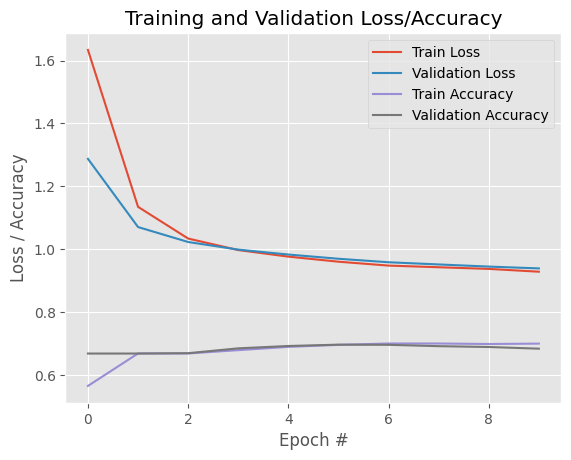

In [56]:
# Mis valores únicos de la variable objetivo serán las diferentes clases del modelo, por narices
# tiene que coindicir con el numeros de clases de la última capa de la red neuronal, si no da error.
unique_values = len(np.unique(df_tab["dx"])) # Para este caso len(np.unique(df_tab_img["dx"])) = len(np.unique(df_tab["dx"]))


# Codificación One-Hot para las etiquetas
y_train_tab = to_categorical(y_train_tab, num_classes=unique_values)
y_validation_tab = to_categorical(y_validation_tab, num_classes=unique_values)
y_test_tab = to_categorical(y_test_tab, num_classes=unique_values)


# hiperparámetros para el entrenamiento
learning_rate = 0.001
num_epochs = 10
batch_size = 128
activation_function = tf.nn.leaky_relu


# Definir el modelo de red neuronal en modo secuencial
# model_tab = Sequential(
#     [
#       Dense(32, activation="relu", input_shape=(X_train_tab.shape[-1],), name="initial_layer"), # Reducción de neuronas a una cantidad más equilibrada
#       Dense(16, activation=activation_function, name="intermediate_layer_1"),  # Layer = Capa
#       Dense(8, activation=activation_function, name="intermediate_layer_2"),  # kernel = pesos
#       Dense(unique_values, activation='softmax', name="final_layer")  # Softmax para clasificación multi-clase
#     ], name="model_tab"
# )


# Definir el modelo de red neuronal en modo funcional
tabular_input = Input(shape=(X_train_tab.shape[-1],), name="tabular_input")
x = Dense(32, activation="relu", name="initial_layer")(tabular_input)
x = Dense(16, activation=activation_function, name="intermediate_layer_1")(x)
x = Dense(8, activation=activation_function, name="intermediate_layer_2")(x)
output = Dense(unique_values, activation='softmax', name="final_layer")(x)
model_tab = Model(inputs=tabular_input, outputs=output, name="model_tab")


# Usamos el optimizador Adam que adapta el learning rate automáticamente
opt = Adam(learning_rate=learning_rate)

# Compilamos y entrenamos el modelo
model_tab.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Entrenamos el modelo
print("[INFO]: Entrenando red neuronal...")

# en H se guarda el historial del proceso de entrenamiento ('loss', 'accuracy', 'val_loss', 'val_accuracy') para visualización, pero no los pesos entrenados del modelo.
H = model_tab.fit(X_train_tab, y_train_tab, validation_data=(X_validation_tab, y_validation_tab),
              epochs=num_epochs, batch_size=batch_size)

# Evaluamos el modelo de manera precisa
print("[INFO]: Evaluando red neuronal...")
predictions = model_tab.predict(X_test_tab, batch_size=batch_size) # model.predict() usa esos pesos entrenados para hacer predicciones.
print(classification_report(y_true=y_test_tab.argmax(axis=1), y_pred=predictions.argmax(axis=1)))


# Graficamos las pérdidas y las precisiones
plot_train_val_history(history=H, num_epochs=num_epochs)

# Guardo el modelo para poder reutilizarlo en otras partes
model_tab.save('marc_hito1_modelo.keras')

Parece ser que obtengo resultados aceptables (tampoco veo un accuracy muy elevado que podría incluso ser indicio de un sobreajuste). Las pérdidas disminuyen a la vez que el accuracy aumenta un poco, y luego tanto pérdidas como accuracy se mantiene algo más estables pero siguen teniendo una ligera tendencia a disminuir y aumentar respectivamente.
Los resultados tampoco son excepcionales tanto en Test, como en Train y Validation, eso tampoco está mal, nos da cierta garantía a quizás poder generalizar antes otros datasets distintos a los aqui aplicados.

El learning rate lo tengo algo alto.

# 2.Modelo 2D (imágenes): Resolver el problema considerando la información presente en las imágenes empleando para ello al menos una red convolucional.

El procedimiento es similar al apartado anterior, lo único que hay partes que no me harán falta, como la codificación de varaibles categóricas, dado que en el punto 0. Preprocesamiento, ya vimos que no había para imágenes.

Redimensionaré las imágenes, tienen como una especie de Flatten(), son realmente un 28x28x3 aplanado, de ahí el 2352, por eso cada fila/sample tiene 2352 features/columnas.


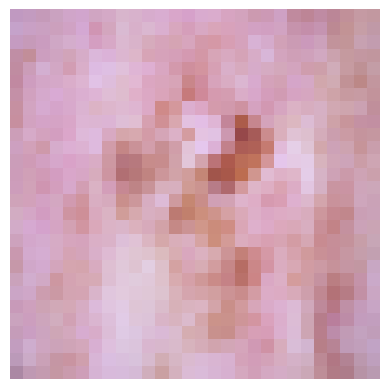

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que cada fila del DataFrame es un vector de píxeles de longitud 28*28*3
def visualizar_imagen(df, indice):
    imagen = df.iloc[indice].values.reshape(28, 28, 3)  # Convertir a formato imagen
    plt.imshow(imagen.astype(np.uint8))  # Asegurar que los valores sean enteros
    plt.axis("off")  # Ocultar los ejes
    plt.show()

# Llamar a la función para ver la imagen en la fila 0
visualizar_imagen(df_img, 0)

In [58]:
# Carga de datos
main_train_data_img = pd.read_csv("HAM10000_metadata_main_train.csv")
main_validation_data_img = pd.read_csv("HAM10000_metadata_main_validation.csv")
all_test_data_img = pd.read_csv("HAM10000_metadata_all_test.csv")

columns_to_drop = ["lesion_id", "image_id", "dx", "dx_type", "age", "sex", "localization"]

# Nos quedamos con las columnas de datos tabulares que queremos
main_train_data_img = main_train_data_img.drop(columns=columns_to_drop)
main_validation_data_img = main_validation_data_img.drop(columns=columns_to_drop)
all_test_data_img = all_test_data_img.drop(columns=columns_to_drop)

In [59]:
def data_imputacion_pixel(data):
    for col in data.columns:
        if data[col].dtype in ['int64', 'float64']:
           data.fillna({col: data[col].mode()[0]}, inplace=True)
    return data

In [60]:
main_train_data_img = data_imputacion_pixel(data=main_train_data_img)
main_validation_data_img = data_imputacion_pixel(data=main_validation_data_img)
all_test_data_img = data_imputacion_pixel(data=all_test_data_img)

In [61]:
X_train_img = main_train_data_img.values
y_train_img = y_train_tab
X_validation_img = main_validation_data_img.values
y_validation_img = y_validation_tab
X_test_img = all_test_data_img.values
y_test_img = y_test_tab

In [62]:
# primero cargamos nuestro dataset y lo redimensionamos a las dimensiones mínimas
# permitidas por la MobileNetV2 -> (96, 96, 3)

def resize_images(dataset, input_shape):
    return np.array([np.resize(img, input_shape) / 255 for img in dataset]) # Convertimos la lista a un array de NumPy

# Definir la forma de entrada
input_shape = (96, 96, 3)

# Aplicar la función a los tres conjuntos de datos
X_train_img_resized = resize_images(X_train_img, input_shape)
X_validation_img_resized = resize_images(X_validation_img, input_shape)
X_test_img_resized = resize_images(X_test_img, input_shape)

# Imprimir las formas resultantes
print(X_train_img_resized.shape)
print(X_validation_img_resized.shape)
print(X_test_img_resized.shape)

(5633, 96, 96, 3)
(1878, 96, 96, 3)
(2504, 96, 96, 3)


In [63]:
# Crear el modelo base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.summary()

Model: "mobilenetv2_1.00_96"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

Voy a mostrar dos forma de construir una misma red neuronal, la manera funcional, y la manera secuencial.

In [64]:
# congelamos todas las capas de nuestro base_model para que no se entrenen
# queremos que nuestro feature extractor siga igual que antes => transfer learning
for layer in base_model.layers:
  layer.trainable = False

#  Definir el modelo de red neuronal en modo secuencial
# model_img = Sequential(
#     [
#       base_model,
#       GlobalAveragePooling2D(),
#       Dense(1024, activation='relu', name='our-fc1'),
#       Dropout(0.5),
#       Dense(unique_values, activation='softmax', name='our-preds')
#     ], name='model_img'
# )

# Definir el modelo de red neuronal en modo funcional
bm_input = base_model.input
last_layer = base_model.layers[-1].output  # cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
x = GlobalAveragePooling2D()(last_layer)
x = Dense(1024, activation='relu', name='our-fc1')(x)
x = Dropout(0.5)(x)
output = Dense(unique_values, activation='softmax', name='our-preds')(x)
model_img = Model(inputs=bm_input, outputs=output, name="model_img")


# compilamos el modelo creado secuencialmente (otra forma de crearlo igual de válida)
opt = Adam(learning_rate=0.001)
model_img.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# vemos la nueva estructura del modelo
model_img.summary()

Model: "model_img"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 3,576,903 (13.64 MB)

 Trainable params: 1,318,919 (5.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 268ms/step - accuracy: 0.7038 - loss: 1.4462 - val_accuracy: 0.8845 - val_loss: 0.3337
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8880 - loss: 0.3347 - val_accuracy: 0.8988 - val_loss: 0.3012
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8856 - loss: 0.3379 - val_accuracy: 0.9058 - val_loss: 0.2724
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9167 - loss: 0.2435 - val_accuracy: 0.9239 - val_loss: 0.2269
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9281 - loss: 0.2128 - val_accuracy: 0.9191 - val_loss: 0.2362
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9360 - loss: 0.1772 - val_accuracy: 0.9302 - val_loss: 0.2112
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9195 - loss: 0.2454 - val_accuracy: 0.9239 - val_loss: 0.2310
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9352 - loss: 0.1885 - val_accuracy: 0.9228 -

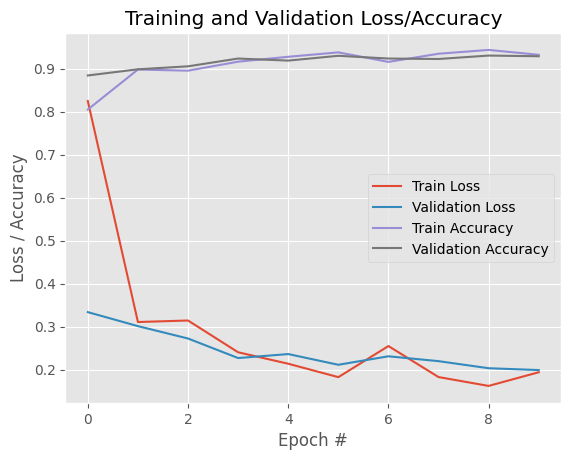

In [65]:
# hiperparámetros para el entrenamiento
learning_rate = 0.001
num_epochs = 10
batch_size = 128

# como entrenariamos normalmente
H = model_img.fit(X_train_img_resized, y_train_img,
          batch_size=batch_size,
          validation_data=(X_validation_img_resized, y_validation_img),
          epochs=num_epochs)

# Evaluamos el modelo de manera precisa
print("[INFO]: Evaluando red neuronal...")
predictions = model_img.predict(X_test_img_resized, batch_size=batch_size) # model_seq.predict() usa esos pesos entrenados para hacer predicciones.
print(classification_report(y_true=y_test_img.argmax(axis=1), y_pred=predictions.argmax(axis=1)))


# Graficamos las pérdidas y las precisiones
plot_train_val_history(history=H, num_epochs=num_epochs)

# Guardo el modelo para poder reutilizarlo en otras partes
model_img.save('marc_hito2_modelo.keras')

Veo unos resultados más sólidos que en el modelo del Hito 1, las curvas son un poco más pronunciadas y hay mejor aprendizaje. Adicionalmente, obtengo unos resultados tanto en Test, como en Train y Validation, que bastante buenos, lo que indica que el modelo preentrenado y la selección de parámetros e inputs es idónea para esta tarea.

Que el modelo de tan buenos resultados, a mi modo de ver es un buen síntoma en cuanto a que la elección de la CNN preentrenada, los parámetros elegidos y demás, ha sido idóneo, tanto que hasta puede haber un cierto indicio a sobreajuste y por ende a no poder generalizar tan bien.

# 3.Estrategia late-fusion: Combinación aprendida de las predicciones realizadas por el modelo 1D y el modelo 2D desarrollados previamente para resolver el problema.

In [66]:
tabular_model = tf.keras.models.load_model('marc_hito1_modelo.keras')
vision_model = tf.keras.models.load_model('marc_hito2_modelo.keras')
print(tabular_model.input_shape[1:])
print(vision_model.input_shape[1:])

(19,)
(96, 96, 3)


In [67]:
def build_late_fusion_model():
    # Consideramos los mismos inputs que cada modelo por separado
    tabular_input = Input(shape=tabular_model.input_shape[1:], name="tabular_input")
    vision_input = Input(shape=vision_model.input_shape[1:], name="vision_input")

    # Obtenemos las predicciones finales para cada modalidad
    tabular_pred = tabular_model(tabular_input)
    vision_pred = vision_model(vision_input)

    # Fusión de las probabilidades concatenadas
    merged = Concatenate()([tabular_pred, vision_pred])

    # Clasificador final
    output = Dense(unique_values, activation="softmax", name="final_output")(merged)

    # Definición final del modelo con nuevo classificador al final
    late_fusion_model = Model(inputs=[tabular_input, vision_input], outputs=output)
    return late_fusion_model

# Crear el modelo de Late Fusion
model_lf = build_late_fusion_model()
model_lf.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tabular_input       │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_input        │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ model_tab           │ (None, 7)         │      1,367 │ tabular_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ model_img           │ (None, 7)         │  3,576,903 │ vision_input[0][… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 14)        │          0 │ model_tab[0][0],  │
│ (Concatenate)       │                   │            │ model_img[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 7)         │        105 │ concatenate_2[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,578,375 (13.65 MB)

 Trainable params: 1,320,391 (5.04 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 235ms/step - accuracy: 0.4483 - loss: 1.6396 - val_accuracy: 0.6842 - val_loss: 1.3540
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6952 - loss: 1.3103 - val_accuracy: 0.6693 - val_loss: 1.2247
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7041 - loss: 1.1848 - val_accuracy: 0.7732 - val_loss: 1.0948
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7761 - loss: 1.0631 - val_accuracy: 0.7694 - val_loss: 0.9997
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7541 - loss: 0.9978 - val_accuracy: 0.7535 - val_loss: 0.9175
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7533 - loss: 0.8931 - val_accuracy: 0.7748 - val_loss: 0.8459
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7865 - loss: 0.8327 - val_accuracy: 0.7774 - val_loss: 0.7973
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7878 - loss: 0.7813 - val_accuracy: 0.7843 -

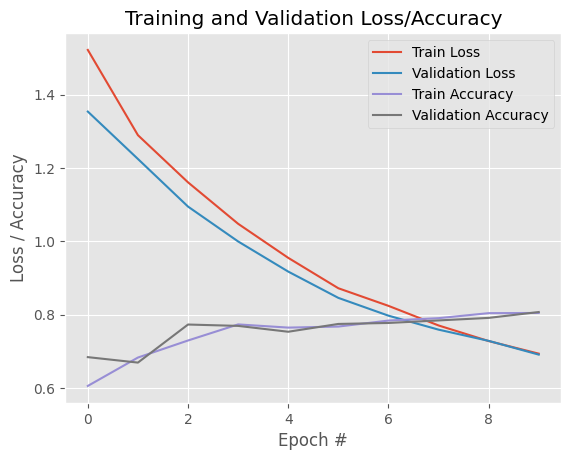

In [68]:
# hiperparámetros para el entrenamiento
learning_rate = 0.001
num_epochs = 10
batch_size = 128

# Compilación del modelo
model_lf.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# Entrenamiento del modelo
H = model_lf.fit([X_train_tab, X_train_img_resized], y_train_tab,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=([X_validation_tab, X_validation_img_resized], y_validation_tab))


# Evaluación del modelo
scores = model_lf.evaluate([X_test_tab, X_test_img_resized], y_test_tab)
print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])


# gráfica función de pérdidas con respecto a las épocas ejecutadas
plot_train_val_history(history=H, num_epochs=num_epochs)

model_lf.save("marc_hito3_modelo.keras")

Se puede observar por los resultados obtenidos y la gráfica que el modelo tabular está lastrando los buenos resultados obtenidos en el visual. Observando la gráfica probablemente ajuste en un futuro el learning rate, dado que en este caso es algo bajo observando las curvas de pérdidas.

# 4.Estrategia early-fusion: Combinación aprendida de las características realizadas por el modelo 1D y el modelo 2D desarrollados previamente para resolver el problema.

In [69]:
vision_model.summary()

Model: "model_img"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 6,214,743 (23.71 MB)

 Trainable params: 1,318,919 (5.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2,637,840 (10.06 MB)

In [70]:
tabular_model.summary()

Model: "model_tab"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tabular_input (InputLayer)      │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ initial_layer (Dense)           │ (None, 32)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ intermediate_layer_1 (Dense)    │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ intermediate_layer_2 (Dense)    │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_layer (Dense)             │ (None, 7)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,103 (16.03 KB)

 Trainable params: 1,367 (5.34 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,736 (10.69 KB)

In [71]:
def build_early_fusion_model():
    # Inputs
    tabular_input = Input(shape=tabular_model.input_shape[1:], name="tabular_input")
    vision_input = Input(shape=vision_model.input_shape[1:], name="vision_input")

    tabular_intermediate = Model(
      inputs=tabular_model.input, outputs=tabular_model.get_layer('intermediate_layer_1').output)
    vision_intermediate = Model(
      inputs=vision_model.input, outputs=vision_model.get_layer('our-fc1').output)

    tabular_features = tabular_intermediate(tabular_input)
    vision_features = vision_intermediate(vision_input)

    # Fusionamos la representación de ambas modalidades
    merged = Concatenate()([tabular_features, vision_features])

    # Añadimos un clasificador, que suele ser más complejo que en late-fusion
    x = Dense(128, activation="relu")(merged)
    x = Dense(64, activation="relu")(x)
    output = Dense(unique_values, activation="softmax", name="final_output")(x)

    early_fusion_model = Model(inputs=[tabular_input, vision_input], outputs=output)
    return early_fusion_model

# Crear el modelo de Early Fusion
model_ef = build_early_fusion_model()
model_ef.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tabular_input       │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_input        │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 16)        │      1,168 │ tabular_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ (None, 1024)      │  3,569,728 │ vision_input[0][… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 1040)      │          0 │ functional_3[0][… │
│ (Concatenate)       │                   │            │ functional_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    133,248 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 7)         │        455 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,712,855 (14.16 MB)

 Trainable params: 1,454,871 (5.55 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - accuracy: 0.7613 - loss: 0.8978 - val_accuracy: 0.9286 - val_loss: 0.2199
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9360 - loss: 0.1989 - val_accuracy: 0.9308 - val_loss: 0.2058
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9545 - loss: 0.1328 - val_accuracy: 0.9324 - val_loss: 0.1944
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9594 - loss: 0.1099 - val_accuracy: 0.9308 - val_loss: 0.1947
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9664 - loss: 0.1022 - val_accuracy: 0.9356 - val_loss: 0.1975
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9751 - loss: 0.0802 - val_accuracy: 0.9372 - val_loss: 0.1857
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9716 - loss: 0.0792 - val_accuracy: 0.9265 - val_loss: 0.2299
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9711 - loss: 0.0812 - val_accuracy: 0.9388 -

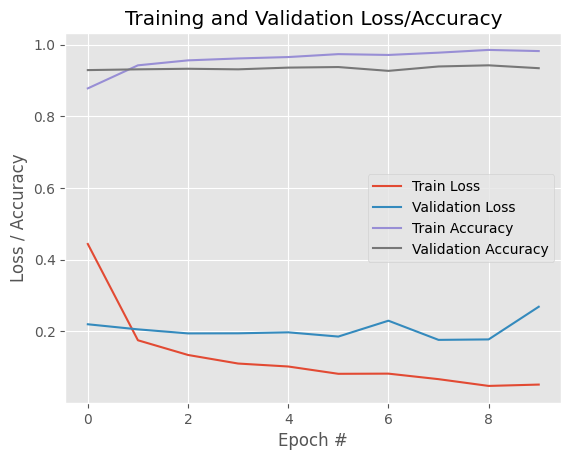

In [72]:
# hiperparámetros para el entrenamiento
learning_rate = 0.001
num_epochs = 10
batch_size = 128

# Compilación del modelo
model_ef.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# Entrenamiento del modelo
H = model_ef.fit([X_train_tab, X_train_img_resized], y_train_tab,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=([X_validation_tab, X_validation_img_resized], y_validation_tab))


# Evaluación del modelo
scores = model_ef.evaluate([X_test_tab, X_test_img_resized], y_test_tab)
print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])


# gráfica función de pérdidas con respecto a las épocas ejecutadas
plot_train_val_history(history=H, num_epochs=num_epochs)

model_ef.save("marc_hito4_modelo.keras")

Esta es la principal razón por la que he me he decantado por usar mis modelos de manera funcional, porque no puedo usar ese código de Early Fusion con dos modelos Sequential si han sido cargados con load_model() o si quiero extraer capas intermedias como 'our-fc1', por eso, LateFusion si funcionaría, pero EarlyFusion no.

Con respecto a los modelos, pues en este caso, es el Early fusion el que mejor resultados me ha dado en relación accuracy-losses, el problema, como todo, es que me parece sospechar de un cierto grado de sobreajuste, que si bien para esta tarea es idóneo, eso implica que antes nuevos datos de otros csv u otras temáticas, quizás no pueda generalizar tan bien y no sea tan reutilizable

In [73]:
tf.keras.backend.clear_session(free_memory=True)